In [1]:
import sys
# setting path
sys.path.append('../')

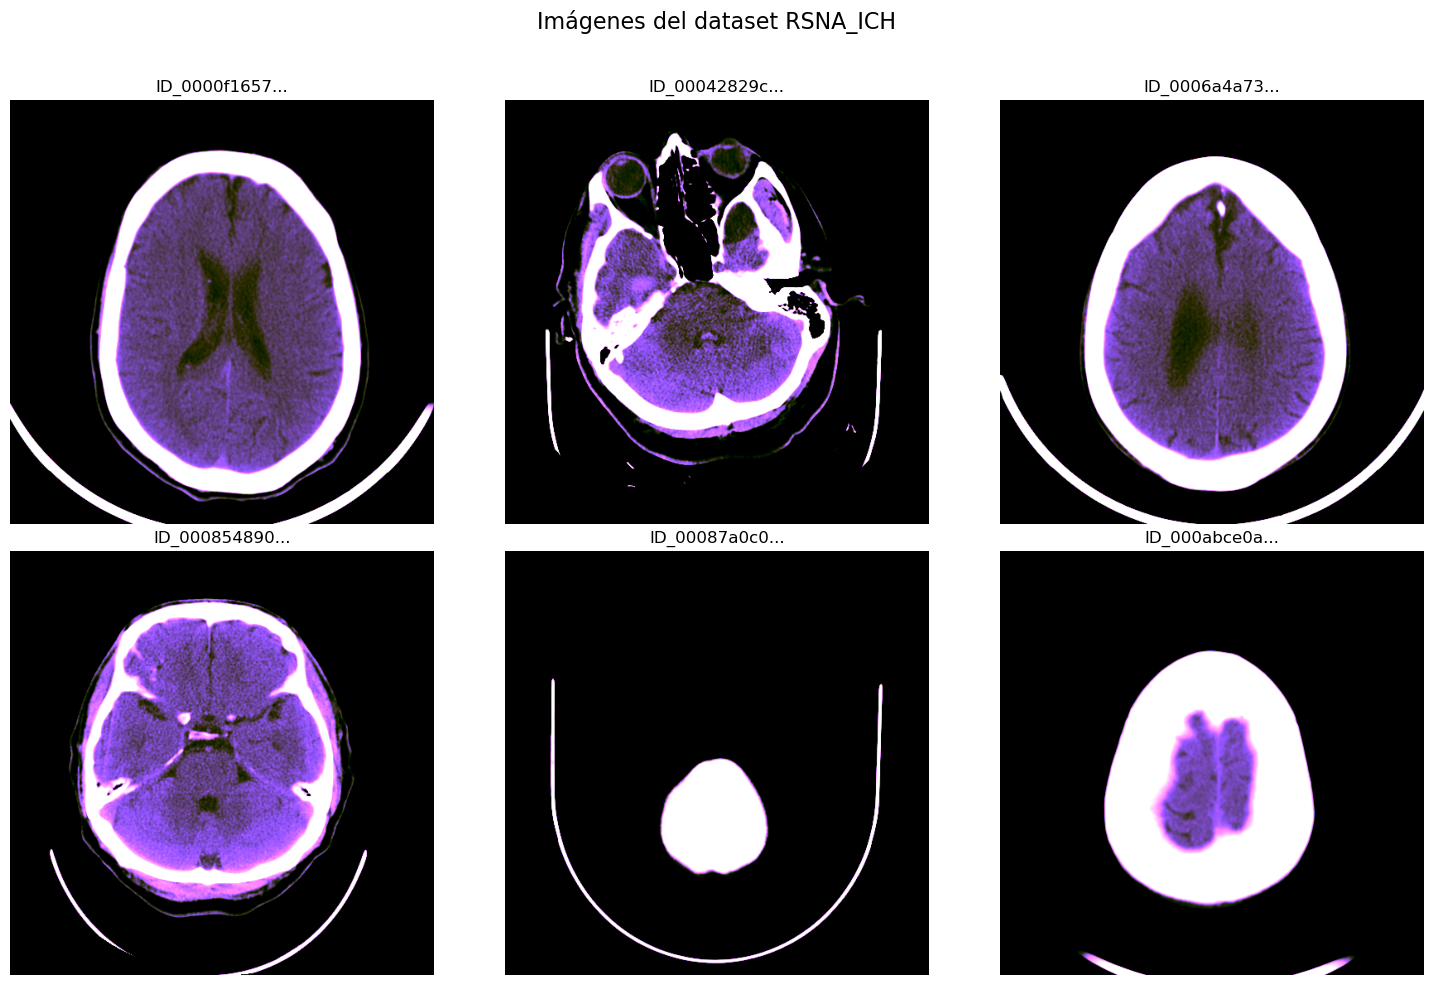

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Ruta absoluta al directorio de las imágenes
NPY_DIR = "/data/datasets/RSNA_ICH/original/"

# Listar los primeros 6 archivos .npy del directorio que comiencen por "ID_"
try:
    all_files = os.listdir(NPY_DIR)
except FileNotFoundError:
    print(f"ERROR: No se pudo encontrar el directorio en la ruta especificada.")
    print(f"Ruta intentada: {os.path.abspath(NPY_DIR)}")
    all_files = []

npy_files = sorted([f for f in all_files if f.startswith("ID_") and f.endswith(".npy")])[:6]

# Asegurarse de que hay al menos 6 archivos
if len(npy_files) < 6:
    print(f"Advertencia: Se encontraron solo {len(npy_files)} archivos de los 6 solicitados.")
    print("Se mostrarán los que se hayan encontrado.")

if npy_files:
    # Un aspect ratio más cuadrado (ej. 15 de ancho por 10 de alto) funciona mejor
    plt.figure(figsize=(15, 10))

    # Recorrer los archivos y mostrarlos
    for i, filename in enumerate(npy_files):
        img_path = os.path.join(NPY_DIR, filename)
        img_array = np.load(img_path)
        
        # --- CAMBIO 3: CREAR UNA CUADRÍCULA DE 2 FILAS Y 3 COLUMNAS ---
        # plt.subplot(filas, columnas, índice)
        plt.subplot(2, 3, i + 1)
        
        plt.imshow(img_array, cmap='gray')
        plt.axis('off')
        plt.title(filename[:12] + "...")

    # Título general de la figura
    plt.suptitle("Imágenes del dataset RSNA_ICH", fontsize=16)

    # --- CAMBIO 4: OPTIMIZAR EL ESPACIO EN BLANCO ---
    # tight_layout() ajusta automáticamente los subplots para que no haya solapamientos
    # y se reduzca el espacio en blanco.
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # El rect ajusta el espacio para el suptitle

    # Mostrar la figura
    plt.show()
else:
    print("No se encontraron imágenes para mostrar.")

/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Iniciando extracción y visualización de tomografías...
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Extrayendo imágenes de la bolsa: ID_fe18e73b79
Se cargaron 28 imágenes de la bolsa ID_fe18e73b79

Bolsa: ID_fe18e73b79
Etiqueta: 1.0
Número de cortes: 28


/tmp/ipykernel_653575/1120862508.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


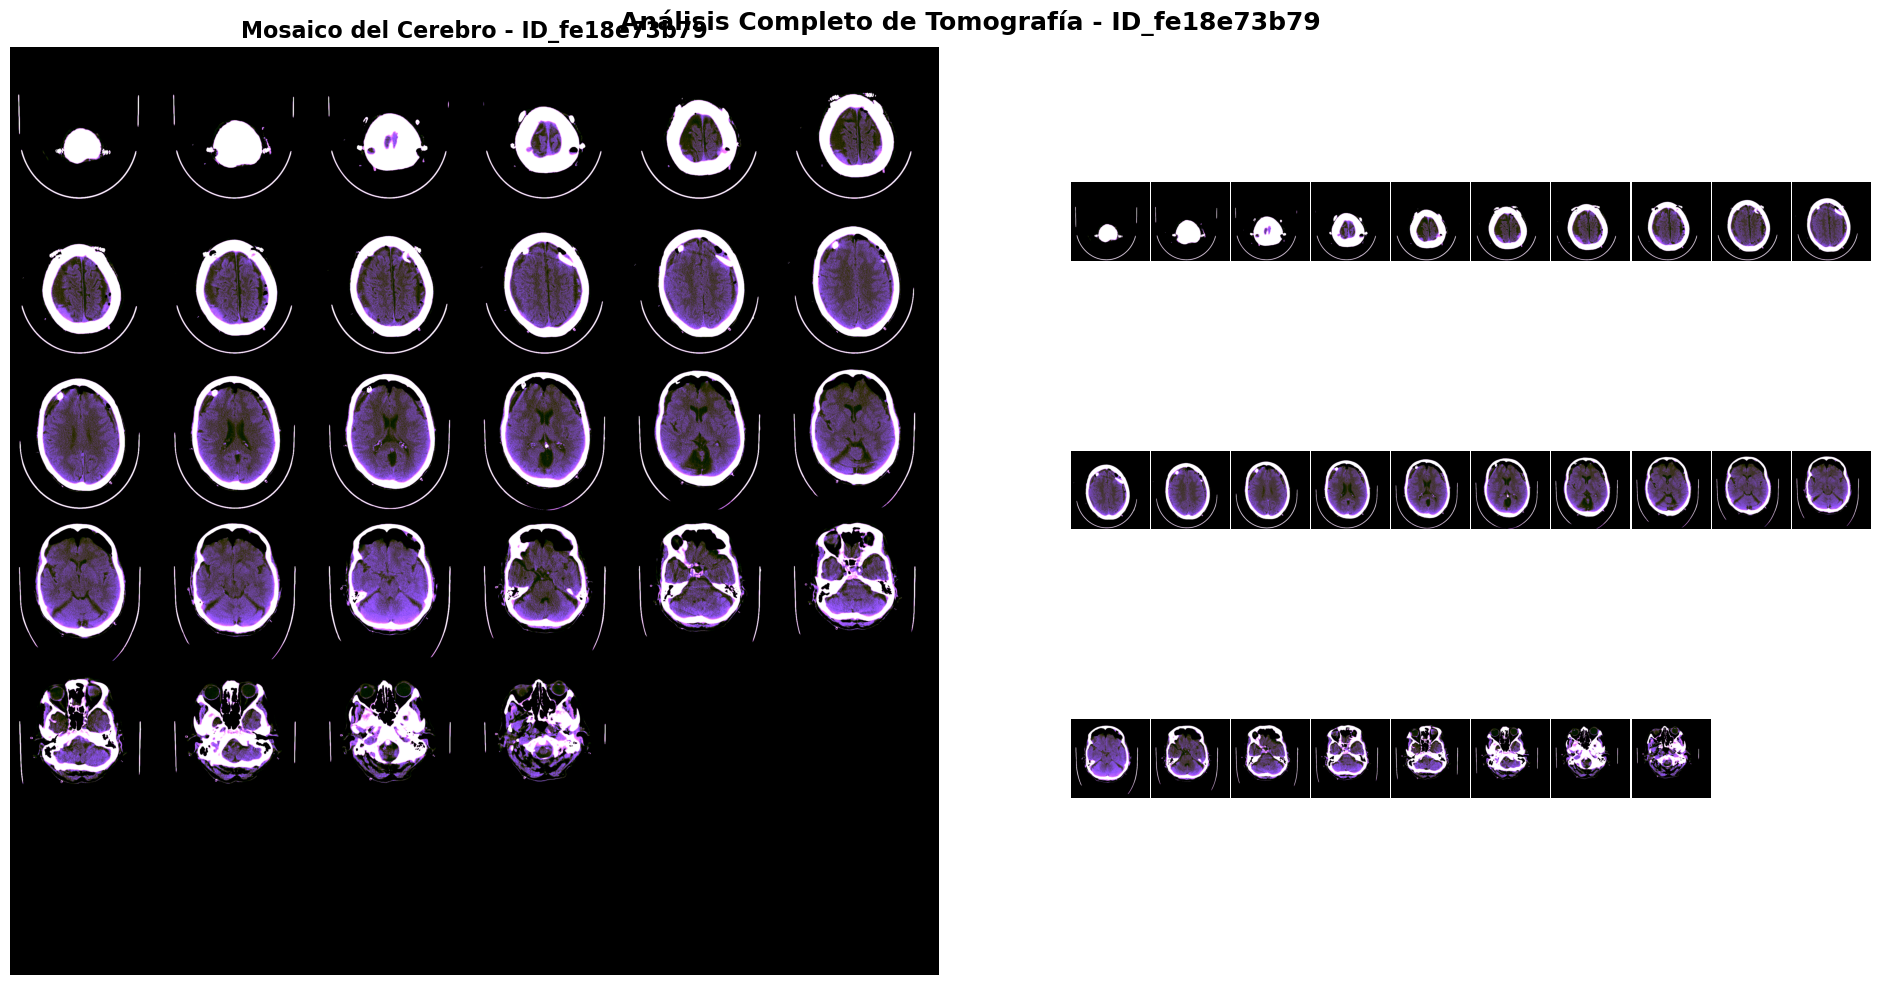


Creando mosaico individual...


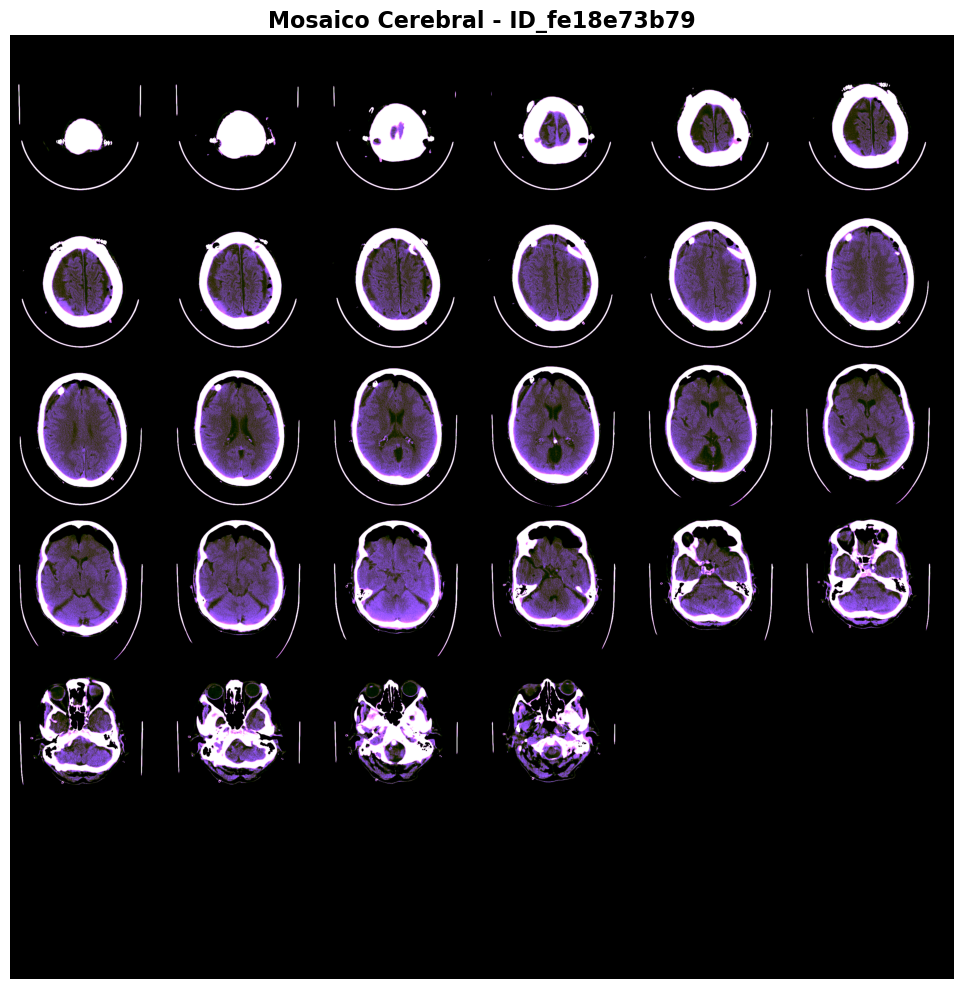


Proceso completado.


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
from argparse import Namespace
import math

# --- CONFIGURACIÓN DE RUTAS E IMPORTACIONES ---
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from scripts.dataset_loader import load_dataset
except (ImportError, ModuleNotFoundError) as e:
    print(f"Error importando módulos: {e}")
    print("Asegúrate de que la estructura de tu proyecto y el `sys.path` son correctos.")
    sys.exit()

def create_brain_mosaic(patches, mosaic_size=None, padding=2):
    """
    Crea un mosaico cuadrado/rectangular con todas las imágenes de tomografía
    """
    if not patches:
        print("No hay parches para crear el mosaico.")
        return None
    
    num_patches = len(patches)
    
    # Calcular el tamaño del mosaico si no se especifica
    if mosaic_size is None:
        side = math.ceil(math.sqrt(num_patches))
        mosaic_size = (side, side)
    
    # Obtener dimensiones del primer parche para normalizar
    sample_patch = patches[0]
    if sample_patch.ndim == 3 and sample_patch.shape[-1] == 1:
        sample_patch = sample_patch.squeeze(axis=-1)
    
    patch_h, patch_w = sample_patch.shape[:2]
    
    # Crear el canvas del mosaico
    mosaic_h = mosaic_size[0] * patch_h + (mosaic_size[0] - 1) * padding
    mosaic_w = mosaic_size[1] * patch_w + (mosaic_size[1] - 1) * padding
    
    # Determinar si es color o escala de grises
    if len(sample_patch.shape) == 3:
        mosaic = np.zeros((mosaic_h, mosaic_w, sample_patch.shape[2]), dtype=sample_patch.dtype)
    else:
        mosaic = np.zeros((mosaic_h, mosaic_w), dtype=sample_patch.dtype)
    
    # Colocar cada parche en el mosaico
    for idx, patch in enumerate(patches):
        if idx >= mosaic_size[0] * mosaic_size[1]:
            break
            
        # Normalizar el parche
        if patch.ndim == 3 and patch.shape[-1] == 1:
            patch = patch.squeeze(axis=-1)
        
        # Calcular posición en el mosaico
        row = idx // mosaic_size[1]
        col = idx % mosaic_size[1]
        
        # Calcular coordenadas de píxeles
        start_y = row * (patch_h + padding)
        end_y = start_y + patch_h
        start_x = col * (patch_w + padding)
        end_x = start_x + patch_w
        
        # Colocar el parche
        mosaic[start_y:end_y, start_x:end_x] = patch
    
    return mosaic

def plot_brain_comparison(patches, bag_id, save_path=None):
    """
    Crea una visualización con el mosaico del cerebro a la izquierda 
    y todas las imágenes individuales a la derecha
    """
    if not patches:
        print("No hay parches para visualizar.")
        return
    
    # Crear el mosaico
    brain_mosaic = create_brain_mosaic(patches)
    
    if brain_mosaic is None:
        return
    
    # Configurar la figura
    fig = plt.figure(figsize=(20, 10))
    
    # Subplot para el mosaico (lado izquierdo)
    ax1 = plt.subplot(1, 2, 1)
    if brain_mosaic.ndim == 2:
        ax1.imshow(brain_mosaic, cmap='gray')
    else:
        ax1.imshow(brain_mosaic)
    ax1.set_title(f'Mosaico del Cerebro - {bag_id}', fontsize=16, fontweight='bold')
    ax1.axis('off')
    
    # Subplot para todas las imágenes individuales (lado derecho)
    ax2 = plt.subplot(1, 2, 2)
    
    # Calcular el grid para las imágenes individuales
    num_patches = len(patches)
    cols = min(10, num_patches)  # Máximo 10 columnas
    rows = math.ceil(num_patches / cols)
    
    # Crear subplots para las imágenes individuales
    gs = fig.add_gridspec(rows, cols, left=0.55, right=0.95, top=0.9, bottom=0.1, 
                         wspace=0.02, hspace=0.02)
    
    for i, patch in enumerate(patches):
        row = i // cols
        col = i % cols
        
        if row >= rows:
            break
            
        ax = fig.add_subplot(gs[row, col])
        
        # Normalizar el parche
        display_patch = patch
        if patch.ndim == 3 and patch.shape[-1] == 1:
            display_patch = patch.squeeze(axis=-1)
        
        # Mostrar la imagen
        if display_patch.ndim == 2:
            ax.imshow(display_patch, cmap='gray')
        else:
            ax.imshow(display_patch)
        
        ax.axis('off')
    
    # Remover el subplot vacío del lado derecho
    ax2.remove()
    
    # Título general
    fig.suptitle(f'Análisis Completo de Tomografía - {bag_id}', fontsize=18, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Imagen guardada en: {save_path}")
    
    plt.show()

def extract_clean_images(dataset, bag_index):
    """
    Extrae todas las imágenes limpias de una bolsa específica
    """
    if bag_index >= len(dataset):
        print(f"Error: Índice {bag_index} fuera de rango.")
        return None, None, None
    
    try:
        bag_id = dataset.bag_names[bag_index]
        print(f"Extrayendo imágenes de la bolsa: {bag_id}")
    except (AttributeError, IndexError):
        print("Error: No se pudo obtener el ID de la bolsa.")
        return None, None, None
    
    # Obtener rutas de las instancias
    try:
        if hasattr(dataset, 'data_dict') and bag_id in dataset.data_dict:
            instance_paths = dataset.data_dict[bag_id]['inst_paths']
            bag_label = dataset.data_dict[bag_id]['bag_label']
        else:
            print("Error: No se pudo acceder a la información de la bolsa.")
            return None, None, None
    except Exception as e:
        print(f"Error al obtener información de la bolsa: {e}")
        return None, None, None
    
    # Cargar todas las imágenes
    clean_images = []
    for img_path in instance_paths:
        if os.path.exists(img_path):
            try:
                img_data = np.load(img_path)
                clean_images.append(img_data)
            except Exception as e:
                print(f"Advertencia: Error al cargar {img_path}: {e}")
        else:
            print(f"Advertencia: Archivo no encontrado: {img_path}")
    
    if not clean_images:
        print("Error: No se pudieron cargar imágenes de la bolsa.")
        return None, None, None
    
    print(f"Se cargaron {len(clean_images)} imágenes de la bolsa {bag_id}")
    return clean_images, bag_id, bag_label

# --- CONFIGURACIÓN PRINCIPAL ---
BAG_INDEX_TO_VISUALIZE = 10

# Configuración del dataset
config_dict = {
    "dataset_name": "rsna", 
    "val_prop": 0.15,
    "seed": 0, 
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
}
config = Namespace(**config_dict)

# --- EJECUCIÓN PRINCIPAL ---
if __name__ == "__main__":
    print("Iniciando extracción y visualización de tomografías...")
    
    # Cargar dataset
    test_dataset = load_dataset(config=config, mode="test")
    
    # Extraer imágenes limpias
    clean_images, bag_id, bag_label = extract_clean_images(test_dataset, BAG_INDEX_TO_VISUALIZE)
    
    if clean_images is not None:
        print(f"\nBolsa: {bag_id}")
        print(f"Etiqueta: {bag_label}")
        print(f"Número de cortes: {len(clean_images)}")
        
        # Crear visualización
        plot_brain_comparison(clean_images, bag_id)
        
        # Opcionalmente, también crear solo el mosaico
        print("\nCreando mosaico individual...")
        brain_mosaic = create_brain_mosaic(clean_images)
        
        if brain_mosaic is not None:
            plt.figure(figsize=(10, 10))
            if brain_mosaic.ndim == 2:
                plt.imshow(brain_mosaic, cmap='gray')
            else:
                plt.imshow(brain_mosaic)
            plt.title(f'Mosaico Cerebral - {bag_id}', fontsize=16, fontweight='bold')
            plt.axis('off')
            plt.tight_layout()
            plt.show()
    
    print("\nProceso completado.")

/tmp/ipykernel_59888/2201795794.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


Modelo cargado desde: models/rsna/attention/seed0/model.pth
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Bag ID para índice 10: ID_fe18e73b79

Visualizando bolsa: ID_fe18e73b79
Predicción: 0.7480
Etiqueta real: 1.0


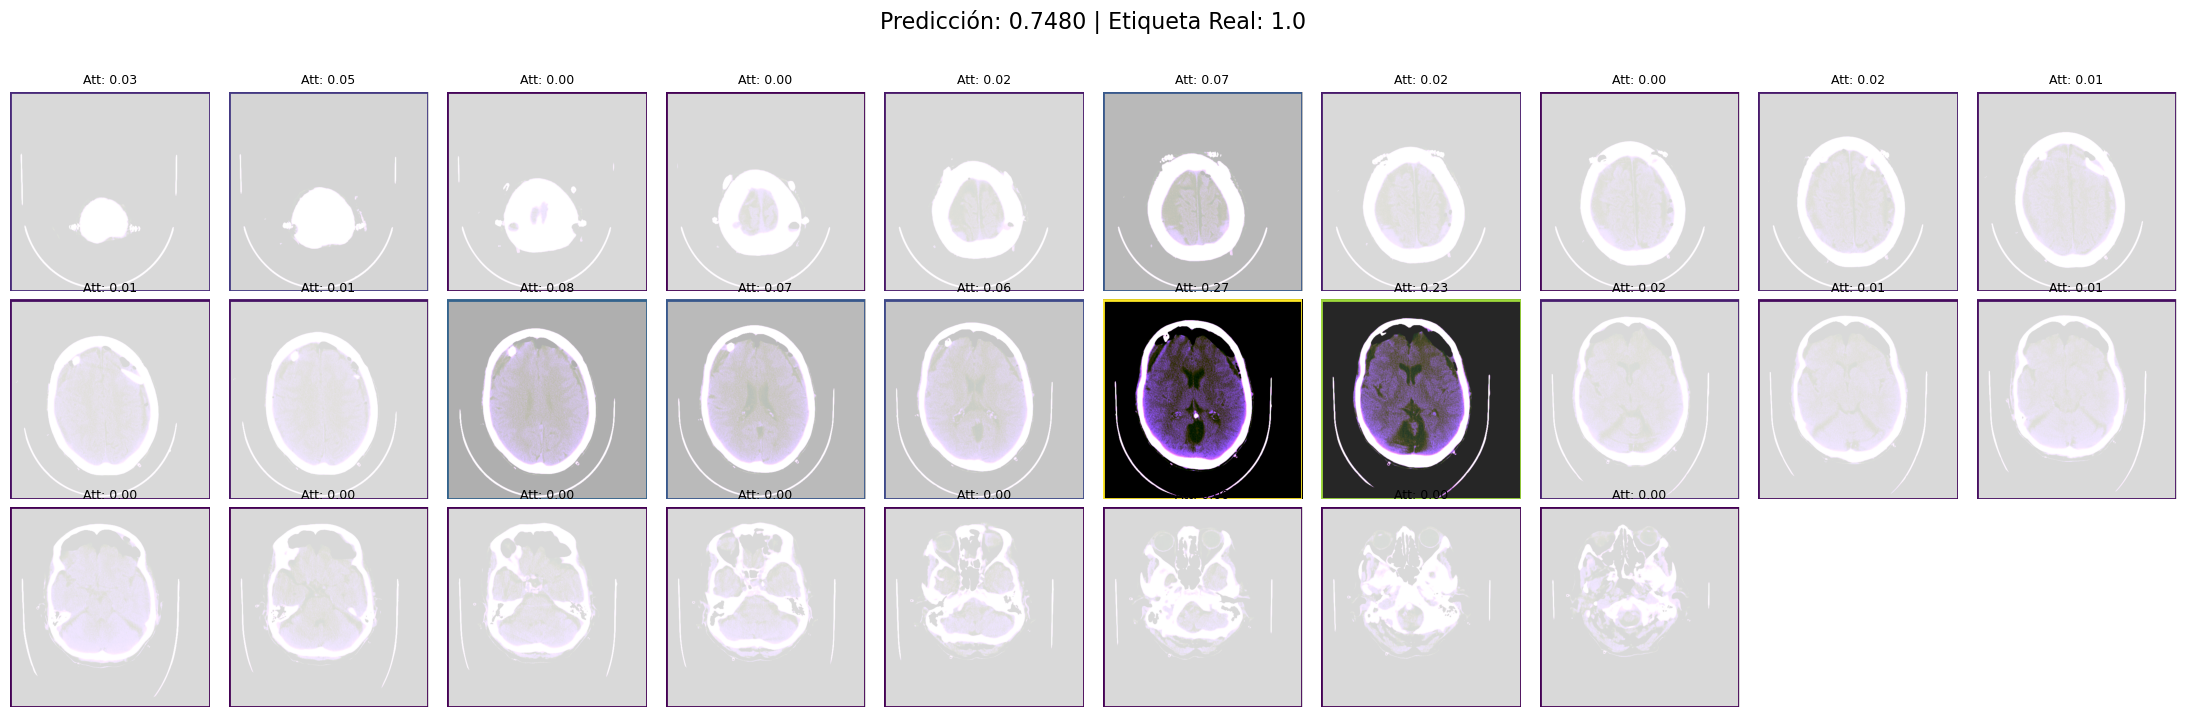


Proceso de visualización completado.


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
from argparse import Namespace

# --- CONFIGURACIÓN DE RUTAS E IMPORTACIONES ---
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from scripts.dataset_loader import load_dataset
    from scripts.MIL_utils import MIL_collate_fn
    from scripts.model import MILModel
    from scripts.plot_utils import normalize 
except (ImportError, ModuleNotFoundError) as e:
    print(f"Error importando módulos: {e}")
    print("Asegúrate de que la estructura de tu proyecto y el `sys.path` son correctos.")
    sys.exit()

# --- Función de Ploteo Personalizada para Slices de CT con Alpha ---
def plot_ct_slices_and_heatmap(patches, attention_scores_normalized, attention_scores_raw, bag_id, pred_prob, true_label, num_cols=10, min_alpha=0.15):
    """
    Visualiza todas las slices de CT de una bolsa.
    Usa los pesos de atención NORMALIZADOS para la transparencia y borde,
    y los pesos de atención CRUDOS para el texto en el título del subplot.
    """
    if len(patches) != len(attention_scores_normalized) or len(patches) != len(attention_scores_raw):
        print("Advertencia: El número de parches, pesos de atención normalizados o crudos no coincide. Ajustando al menor número.")
        min_len = min(len(patches), len(attention_scores_normalized), len(attention_scores_raw))
        patches = patches[:min_len]
        attention_scores_normalized = attention_scores_normalized[:min_len]
        attention_scores_raw = attention_scores_raw[:min_len]
        if min_len == 0:
            print("No hay parches o scores para visualizar.")
            return

    num_patches = len(patches)
    num_rows = (num_patches + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2.2, num_rows * 2.5))
    axes = axes.flatten()
    
    # Título de la figura reducido como solicitado
    fig.suptitle(f"Predicción: {pred_prob:.4f} | Etiqueta Real: {true_label}", fontsize=16)

    for i in range(num_patches):
        if i >= len(axes): 
            break
        
        ax = axes[i]
        current_patch = patches[i]
        current_attention_normalized = attention_scores_normalized[i] 
        current_attention_raw = attention_scores_raw[i] 

        display_alpha = max(current_attention_normalized, min_alpha)
        
        if current_patch.ndim == 3 and current_patch.shape[-1] == 3:
            ax.imshow(current_patch, alpha=display_alpha) 
        elif current_patch.ndim == 2:
            ax.imshow(current_patch, cmap='gray', alpha=display_alpha)
        elif current_patch.ndim == 3 and current_patch.shape[-1] == 1:
             ax.imshow(current_patch.squeeze(axis=-1), cmap='gray', alpha=display_alpha)
        else:
            ax.set_title(f"Inválido\nAtt: {current_attention_raw:.2f}", fontsize=8)
            ax.axis('off')
            continue

        # Usar la atención RAW para el título del subplot
        ax.set_title(f"Att: {current_attention_raw:.2f}", fontsize=9, 
                     color='red' if current_attention_raw > 0.7 else ('orange' if current_attention_raw > 0.4 else 'black'))
        ax.axis('off')

        rect = plt.Rectangle((0, 0), current_patch.shape[1]-1, current_patch.shape[0]-1, 
                             linewidth=2, edgecolor=plt.cm.viridis(current_attention_normalized), facecolor='none', alpha=1.0)
        ax.add_patch(rect)

    for i in range(num_patches, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- FIN DE LA FUNCIÓN DE PLOTEO CUSTOM ---


# --- PARÁMETROS DE VISUALIZACIÓN ---
MODEL_PATH = "models/rsna/attention/seed0/model.pth" 
ORIGINAL_DATA_DIR = "/data/datasets/RSNA_ICH/original/" # No se usa directamente aquí, pero es buen info
BAG_INDEX_TO_VISUALIZE = 10 

config_dict = {
    "dataset_name": "rsna", 
    "val_prop": 0.15,
    "seed": 0, 
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
}
config = Namespace(**config_dict)

INPUT_FEATURE_DIM = 512 
FEATURE_DIM = 128

# --- 1. CARGAR MODELO Y DATASET ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MILModel(
    pooling_type='attention',
    input_feature_dim=INPUT_FEATURE_DIM,
    feature_dim=FEATURE_DIM
)

try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
    model.eval()
    print(f"Modelo cargado desde: {MODEL_PATH}")
except FileNotFoundError:
    print(f"ERROR: No se encontró el modelo en: {MODEL_PATH}")
    sys.exit()
except Exception as e:
    print(f"ERROR al cargar el modelo: {e}")
    sys.exit()

# --- CARGA DE DATASETS SEPARADOS PARA FEATURES Y IMÁGENES ---
config_features = Namespace(**{
    "dataset_name": "rsna-features_resnet18", 
    "val_prop": 0.15, "seed": config.seed, "use_inst_distances": False, "adj_mat_mode": "relative"
})
test_dataset_features = load_dataset(config=config_features, mode="test")

config_images = Namespace(**{
    "dataset_name": "rsna", 
    "val_prop": 0.15, "seed": config.seed, "use_inst_distances": False, "adj_mat_mode": "relative"
})
test_dataset_images = load_dataset(config=config_images, mode="test")

if BAG_INDEX_TO_VISUALIZE >= len(test_dataset_features) or BAG_INDEX_TO_VISUALIZE >= len(test_dataset_images):
    print(f"Error: BAG_INDEX_TO_VISUALIZE ({BAG_INDEX_TO_VISUALIZE}) fuera de rango.")
    sys.exit()

sample_features = test_dataset_features[BAG_INDEX_TO_VISUALIZE]
bag_features_for_model = sample_features[0] 
bag_label = sample_features[1] 

try:
    bag_id = test_dataset_images.bag_names[BAG_INDEX_TO_VISUALIZE]
    print(f"Bag ID para índice {BAG_INDEX_TO_VISUALIZE}: {bag_id}")
except AttributeError:
    print("Error: 'bag_names' no encontrado en el dataset de IMÁGENES.")
    sys.exit()
except IndexError:
    print(f"Error: Índice {BAG_INDEX_TO_VISUALIZE} fuera de rango para 'bag_names'.")
    sys.exit()

instance_paths_for_images = []
try:
    if hasattr(test_dataset_images, 'data_dict') and bag_id in test_dataset_images.data_dict:
        instance_paths_for_images = test_dataset_images.data_dict[bag_id]['inst_paths']
    else:
        raise AttributeError("El dataset de IMÁGENES no tiene 'data_dict' o 'bag_id' inválido.")
except (AttributeError, KeyError) as e:
    print(f"Error al obtener rutas de IMÁGENES para '{bag_id}': {e}")
    sys.exit()


# --- 2. OBTENER PESOS DE ATENCIÓN (USANDO FEATURES) ---
with torch.no_grad():
    bag_tensor = bag_features_for_model.unsqueeze(0).to(device) 
    prediction, attention_weights_raw = model(bag_tensor)
    attention_weights_raw = attention_weights_raw.squeeze(0).cpu().numpy()
    prediction_prob = torch.sigmoid(prediction).item()

# NORMALIZAR LOS PESOS DE ATENCIÓN
normalized_attention = normalize(attention_weights_raw) 


# --- 3. CARGAR IMÁGENES ORIGINALES DE LOS PARCHES (PARA VISUALIZACIÓN) ---
patches_image_data = [] 
if instance_paths_for_images: 
    for p_path in instance_paths_for_images:
        full_path = p_path 
        
        if os.path.exists(full_path):
            try:
                img_data = np.load(full_path)
                
                if img_data.ndim == 2 or (img_data.ndim == 3 and img_data.shape[-1] in [3, 4]):
                    patches_image_data.append(img_data)
                elif img_data.ndim == 3 and img_data.shape[-1] == 1:
                    patches_image_data.append(img_data.squeeze(axis=-1))
                # No necesitamos el else aquí, el error ya se maneja en el plotter
            except Exception as e:
                print(f"Advertencia: Error al cargar/procesar {full_path}: {e}")
        else:
            print(f"Advertencia: Parche de imagen no encontrado: {full_path}")

if not patches_image_data:
    print("Error: No se pudieron cargar parches para la visualización. Verifica rutas.")
    sys.exit()
else:
    # --- 4. VISUALIZACIÓN ---
    print(f"\nVisualizando bolsa: {bag_id}")
    print(f"Predicción: {prediction_prob:.4f}")
    print(f"Etiqueta real: {bag_label.item()}") 

    plot_ct_slices_and_heatmap(
        patches=patches_image_data, 
        attention_scores_normalized=normalized_attention,
        attention_scores_raw=attention_weights_raw,       
        bag_id=bag_id, # Se sigue pasando para el nombre del archivo si se guarda, aunque no en el título del plot
        pred_prob=prediction_prob,
        true_label=bag_label.item()
    )

print("\nProceso de visualización completado.")

/tmp/ipykernel_59888/2399441062.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


Modelo cargado desde: models/rsna/attention/seed0/model.pth
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Buscando 5 bolsas en el dataset de test con Etiqueta Real = 0...


Buscando bolsas negativas:   8%|▊         | 12/150 [00:00<00:01, 100.51it/s]

Encontradas 5 bolsas con Etiqueta Real = 0.

--- Visualizando Bolsa 1 de 5 (Índice en dataset: 0) ---
Bag ID para esta bolsa: ID_00047d6503


Predicción: 0.4815
Etiqueta real de la bolsa: 0.0


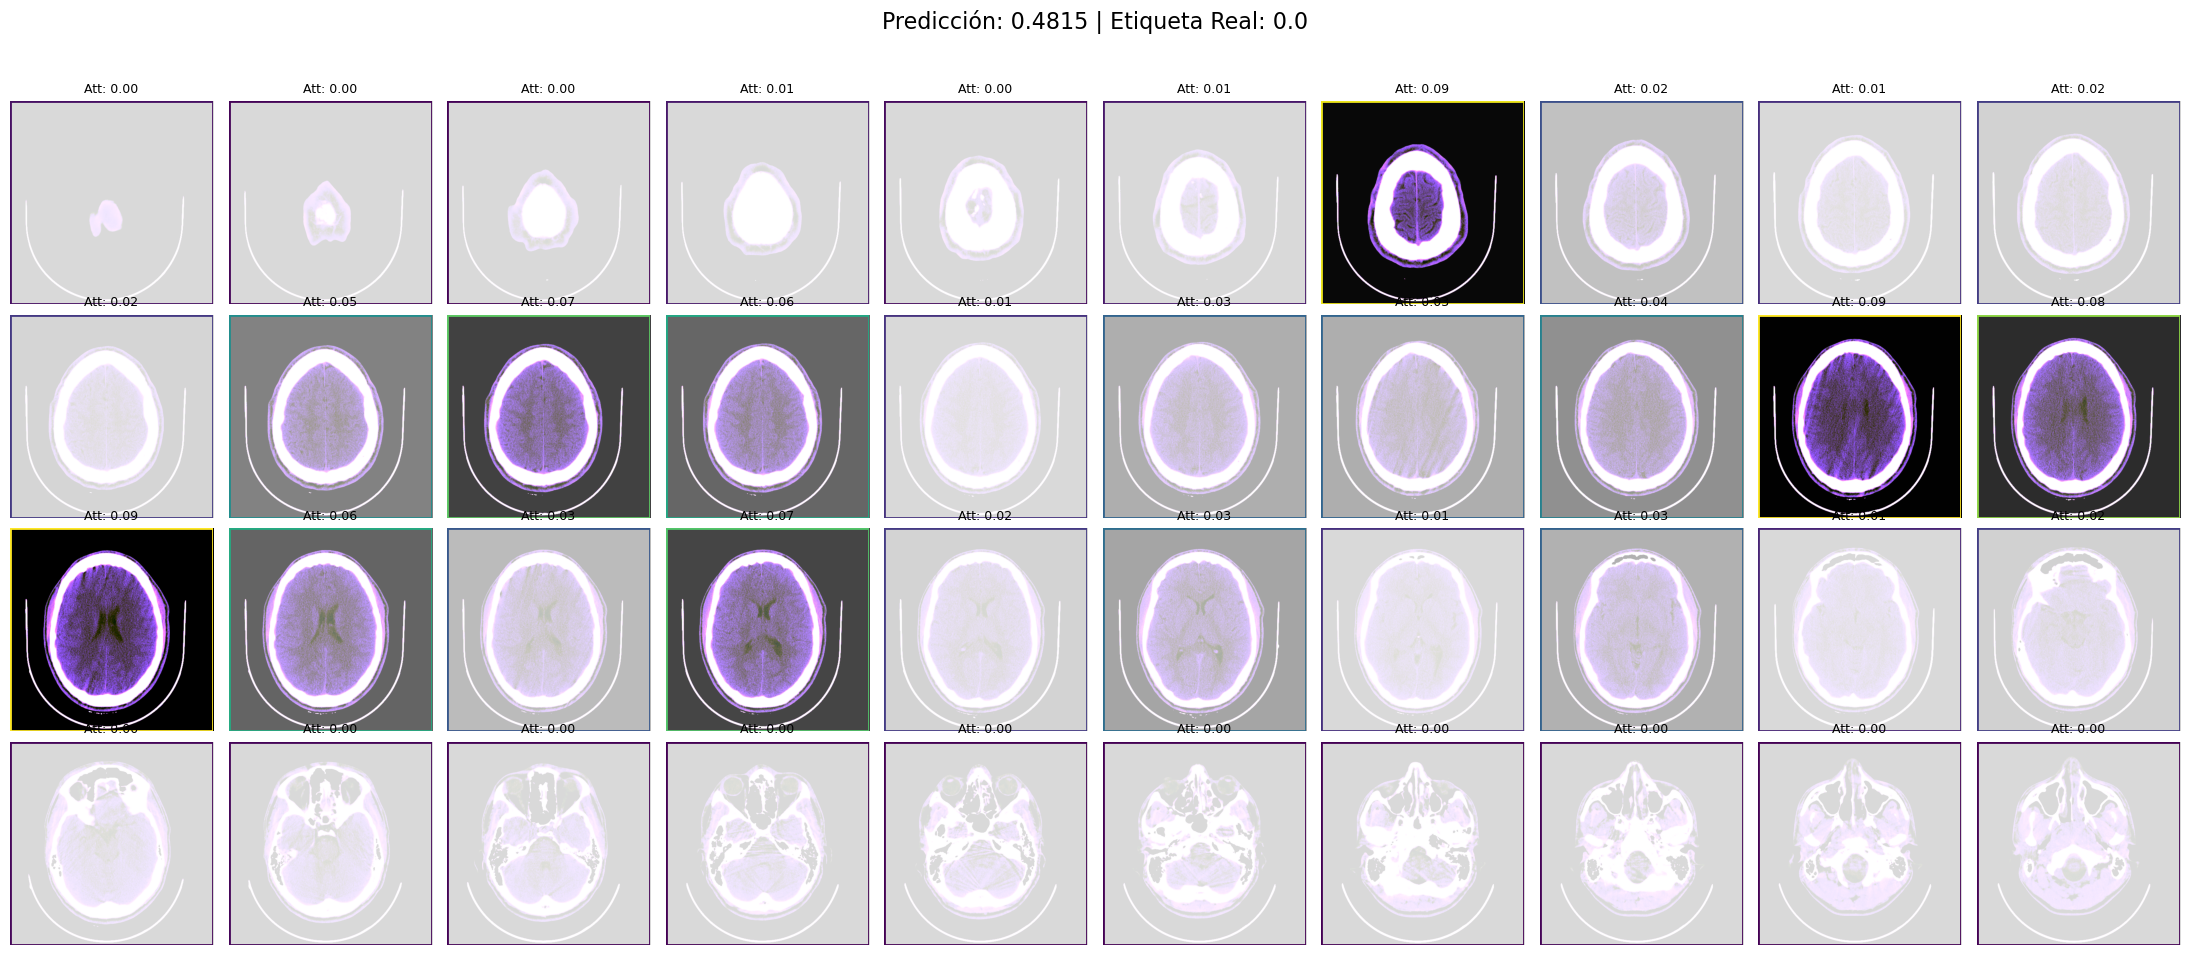


--- Visualizando Bolsa 2 de 5 (Índice en dataset: 2) ---
Bag ID para esta bolsa: ID_fdf99b7e52
Predicción: 0.0445
Etiqueta real de la bolsa: 0.0


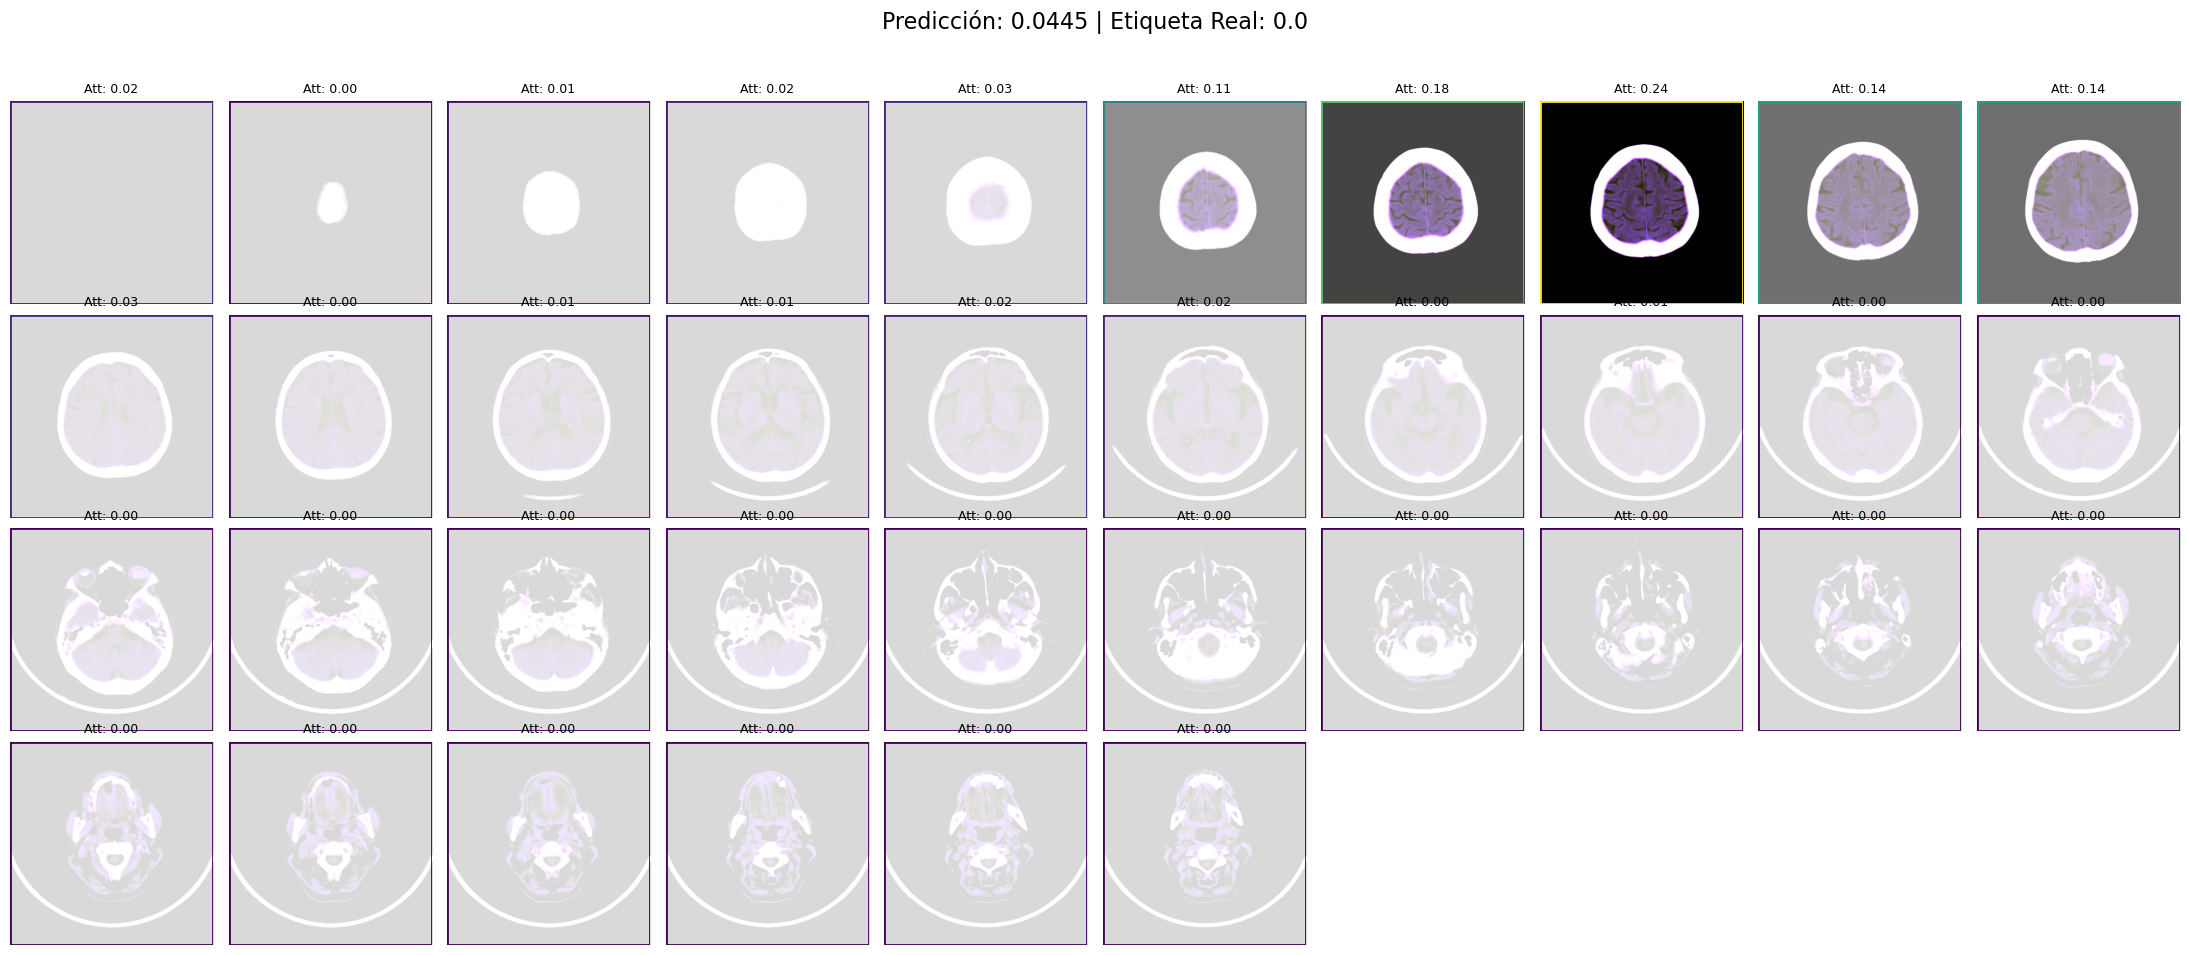


--- Visualizando Bolsa 3 de 5 (Índice en dataset: 3) ---
Bag ID para esta bolsa: ID_fdfbb2597f
Predicción: 0.6864
Etiqueta real de la bolsa: 0.0


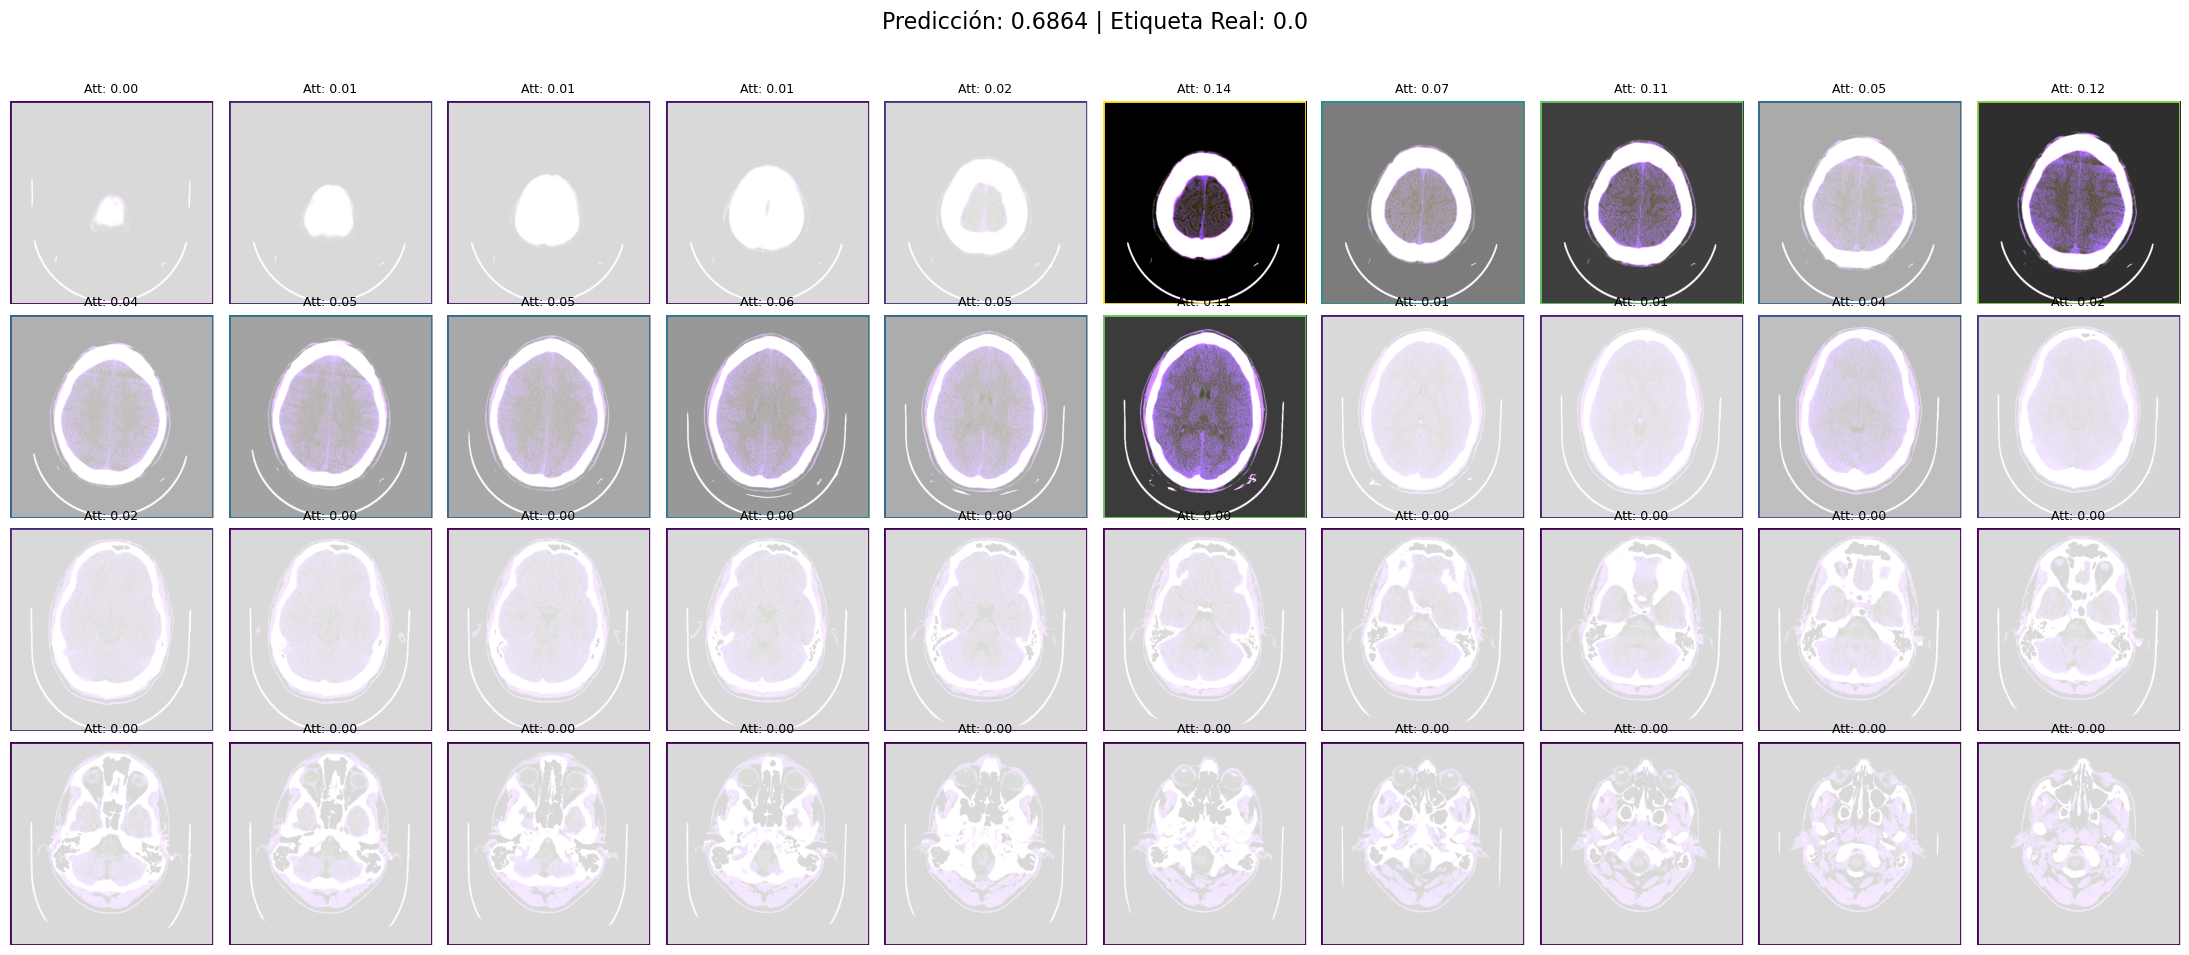


--- Visualizando Bolsa 4 de 5 (Índice en dataset: 8) ---
Bag ID para esta bolsa: ID_fe118c39b7
Predicción: 0.1790
Etiqueta real de la bolsa: 0.0


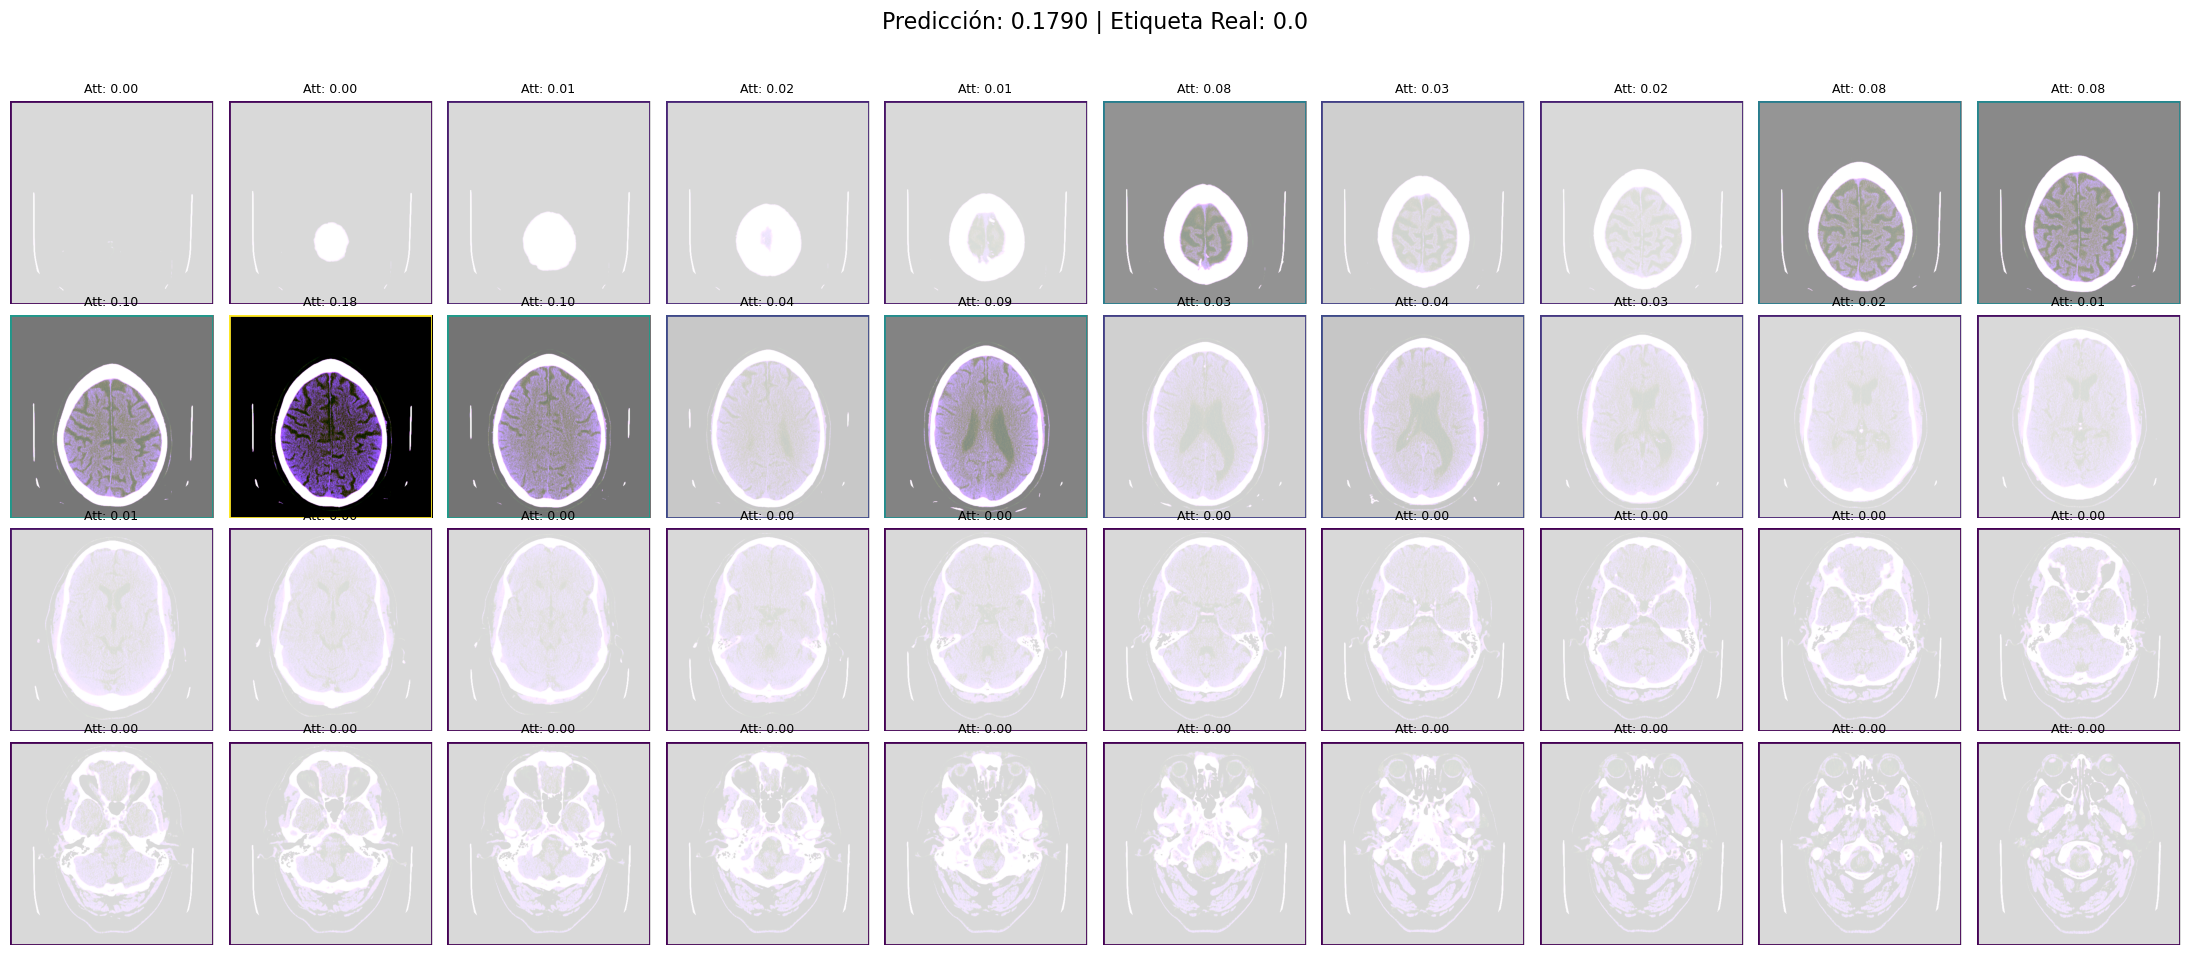


--- Visualizando Bolsa 5 de 5 (Índice en dataset: 12) ---
Bag ID para esta bolsa: ID_fe236189fb
Predicción: 0.1066
Etiqueta real de la bolsa: 0.0


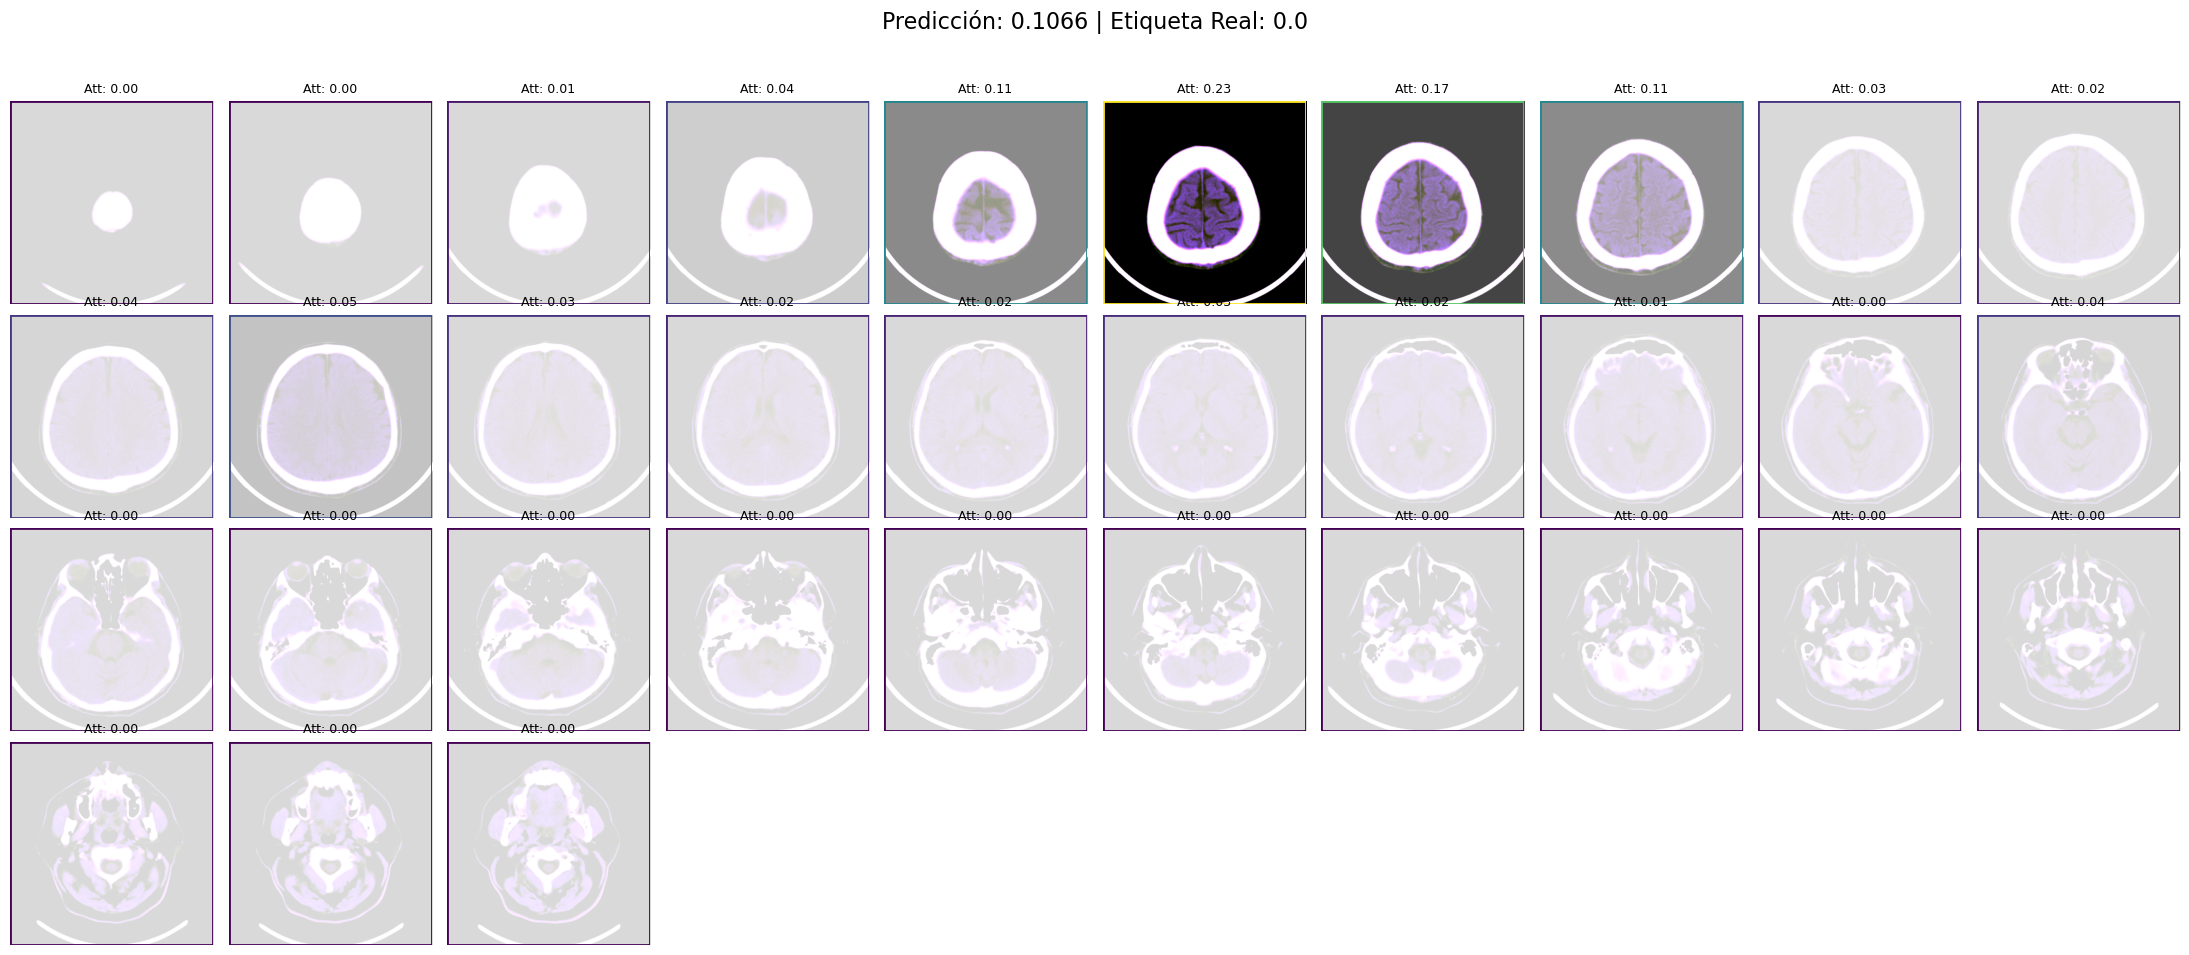


Proceso de visualización de múltiples bolsas completado.


In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
from argparse import Namespace
from tqdm import tqdm # Importar tqdm para la barra de progreso

# --- CONFIGURACIÓN DE RUTAS E IMPORTACIONES ---
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from scripts.dataset_loader import load_dataset
    from scripts.MIL_utils import MIL_collate_fn
    from scripts.model import MILModel
    from scripts.plot_utils import normalize 
except (ImportError, ModuleNotFoundError) as e:
    print(f"Error importando módulos: {e}")
    print("Asegúrate de que la estructura de tu proyecto y el `sys.path` son correctos.")
    sys.exit()

# --- Función de Ploteo Personalizada para Slices de CT con Alpha ---
def plot_ct_slices_and_heatmap(patches, attention_scores_normalized, attention_scores_raw, bag_id, pred_prob, true_label, num_cols=10, min_alpha=0.15):
    """
    Visualiza todas las slices de CT de una bolsa.
    Usa los pesos de atención NORMALIZADOS para la transparencia y borde,
    y los pesos de atención CRUDOS para el texto en el título del subplot.
    """
    if len(patches) != len(attention_scores_normalized) or len(patches) != len(attention_scores_raw):
        print("Advertencia: El número de parches, pesos de atención normalizados o crudos no coincide. Ajustando al menor número.")
        min_len = min(len(patches), len(attention_scores_normalized), len(attention_scores_raw))
        patches = patches[:min_len]
        attention_scores_normalized = attention_scores_normalized[:min_len]
        attention_scores_raw = attention_scores_raw[:min_len]
        if min_len == 0:
            print("No hay parches o scores para visualizar.")
            return

    num_patches = len(patches)
    num_rows = (num_patches + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2.2, num_rows * 2.5))
    axes = axes.flatten()
    
    # Título de la figura: Predicción y Etiqueta Real
    fig.suptitle(f"Predicción: {pred_prob:.4f} | Etiqueta Real: {true_label}", fontsize=16)

    for i in range(num_patches):
        if i >= len(axes): 
            break
        
        ax = axes[i]
        current_patch = patches[i]
        current_attention_normalized = attention_scores_normalized[i] 
        current_attention_raw = attention_scores_raw[i] 

        display_alpha = max(current_attention_normalized, min_alpha)
        
        if current_patch.ndim == 3 and current_patch.shape[-1] == 3:
            ax.imshow(current_patch, alpha=display_alpha) 
        elif current_patch.ndim == 2:
            ax.imshow(current_patch, cmap='gray', alpha=display_alpha)
        elif current_patch.ndim == 3 and current_patch.shape[-1] == 1:
             ax.imshow(current_patch.squeeze(axis=-1), cmap='gray', alpha=display_alpha)
        else:
            ax.set_title(f"Inválido\nAtt: {current_attention_raw:.2f}", fontsize=8)
            ax.axis('off')
            continue

        ax.set_title(f"Att: {current_attention_raw:.2f}", fontsize=9, 
                     color='red' if current_attention_raw > 0.7 else ('orange' if current_attention_raw > 0.4 else 'black'))
        ax.axis('off')

        rect = plt.Rectangle((0, 0), current_patch.shape[1]-1, current_patch.shape[0]-1, 
                             linewidth=2, edgecolor=plt.cm.viridis(current_attention_normalized), facecolor='none', alpha=1.0)
        ax.add_patch(rect)

    for i in range(num_patches, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- FIN DE LA FUNCIÓN DE PLOTEO CUSTOM ---


# --- PARÁMETROS DE VISUALIZACIÓN ---
MODEL_PATH = "models/rsna/attention/seed0/model.pth" 
ORIGINAL_DATA_DIR = "/data/datasets/RSNA_ICH/original/" 
NUM_NEG_BAGS_TO_SHOW = 5 # <--- NUEVO PARÁMETRO: Cuántas bolsas negativas mostrar

config_dict = {
    "dataset_name": "rsna", 
    "val_prop": 0.15,
    "seed": 0, 
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
}
config = Namespace(**config_dict)

INPUT_FEATURE_DIM = 512 
FEATURE_DIM = 128

# --- 1. CARGAR MODELO Y DATASET ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MILModel(
    pooling_type='attention',
    input_feature_dim=INPUT_FEATURE_DIM,
    feature_dim=FEATURE_DIM
)

try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
    model.eval()
    print(f"Modelo cargado desde: {MODEL_PATH}")
except FileNotFoundError:
    print(f"ERROR: No se encontró el modelo en: {MODEL_PATH}")
    sys.exit()
except Exception as e:
    print(f"ERROR al cargar el modelo: {e}")
    sys.exit()

# --- CARGA DE DATASETS SEPARADOS PARA FEATURES Y IMÁGENES ---
config_features = Namespace(**{
    "dataset_name": "rsna-features_resnet18", 
    "val_prop": 0.15, "seed": config.seed, "use_inst_distances": False, "adj_mat_mode": "relative"
})
test_dataset_features = load_dataset(config=config_features, mode="test")

config_images = Namespace(**{
    "dataset_name": "rsna", 
    "val_prop": 0.15, "seed": config.seed, "use_inst_distances": False, "adj_mat_mode": "relative"
})
test_dataset_images = load_dataset(config=config_images, mode="test")


# --- BÚSQUEDA DE BOLSAS CON ETIQUETA REAL = 0 ---
found_bag_indices = []
print(f"Buscando {NUM_NEG_BAGS_TO_SHOW} bolsas en el dataset de test con Etiqueta Real = 0...")
for i in tqdm(range(len(test_dataset_features)), desc="Buscando bolsas negativas"):
    _, current_bag_label, *rest_info = test_dataset_features[i]
    if current_bag_label.item() == 0:
        found_bag_indices.append(i)
        if len(found_bag_indices) >= NUM_NEG_BAGS_TO_SHOW:
            break # Detener la búsqueda si ya tenemos suficientes

if not found_bag_indices:
    print("Error: No se encontró ninguna bolsa con Etiqueta Real = 0 en el dataset de test.")
    sys.exit()
else:
    print(f"Encontradas {len(found_bag_indices)} bolsas con Etiqueta Real = 0.")


# --- BUCLE PARA PROCESAR Y VISUALIZAR CADA BOLSA ENCONTRADA ---
for i, BAG_INDEX_TO_VISUALIZE in enumerate(found_bag_indices):
    print(f"\n--- Visualizando Bolsa {i+1} de {len(found_bag_indices)} (Índice en dataset: {BAG_INDEX_TO_VISUALIZE}) ---")

    sample_features = test_dataset_features[BAG_INDEX_TO_VISUALIZE]
    bag_features_for_model = sample_features[0] 
    bag_label = sample_features[1] 

    try:
        bag_id = test_dataset_images.bag_names[BAG_INDEX_TO_VISUALIZE]
        print(f"Bag ID para esta bolsa: {bag_id}")
    except AttributeError:
        print("Error: 'bag_names' no encontrado en el dataset de IMÁGENES.")
        continue # Saltar esta bolsa si no se puede obtener el ID
    except IndexError:
        print(f"Error: Índice {BAG_INDEX_TO_VISUALIZE} fuera de rango para 'bag_names'.")
        continue # Saltar esta bolsa si el índice es inválido

    instance_paths_for_images = []
    try:
        if hasattr(test_dataset_images, 'data_dict') and bag_id in test_dataset_images.data_dict:
            instance_paths_for_images = test_dataset_images.data_dict[bag_id]['inst_paths']
        else:
            raise AttributeError("El dataset de IMÁGENES no tiene 'data_dict' o 'bag_id' inválido.")
    except (AttributeError, KeyError) as e:
        print(f"Error al obtener rutas de IMÁGENES para '{bag_id}': {e}")
        continue # Saltar esta bolsa si hay problemas con las rutas


    # --- 2. OBTENER PESOS DE ATENCIÓN (USANDO FEATURES) ---
    with torch.no_grad():
        bag_tensor = bag_features_for_model.unsqueeze(0).to(device) 
        prediction, attention_weights_raw = model(bag_tensor)
        attention_weights_raw = attention_weights_raw.squeeze(0).cpu().numpy()
        prediction_prob = torch.sigmoid(prediction).item()

    # NORMALIZAR LOS PESOS DE ATENCIÓN
    normalized_attention = normalize(attention_weights_raw) 


    # --- 3. CARGAR IMÁGENES ORIGINALES DE LOS PARCHES (PARA VISUALIZACIÓN) ---
    patches_image_data = [] 
    if instance_paths_for_images: 
        for p_path in instance_paths_for_images:
            full_path = p_path 
            
            if os.path.exists(full_path):
                try:
                    img_data = np.load(full_path)
                    
                    if img_data.ndim == 2 or (img_data.ndim == 3 and img_data.shape[-1] in [3, 4]):
                        patches_image_data.append(img_data)
                    elif img_data.ndim == 3 and img_data.shape[-1] == 1:
                        patches_image_data.append(img_data.squeeze(axis=-1))
                except Exception as e:
                    print(f"Advertencia: Error al cargar/procesar {full_path}: {e}")
            else:
                print(f"Advertencia: Parche de imagen no encontrado: {full_path}")

    if not patches_image_data:
        print("Error: No se pudieron cargar parches para la visualización. Verifica rutas.")
        continue # Saltar esta bolsa si no hay parches para visualizar
    else:
        # --- 4. VISUALIZACIÓN ---
        print(f"Predicción: {prediction_prob:.4f}")
        print(f"Etiqueta real de la bolsa: {bag_label.item()}")

        plot_ct_slices_and_heatmap(
            patches=patches_image_data, 
            attention_scores_normalized=normalized_attention,
            attention_scores_raw=attention_weights_raw,       
            bag_id=bag_id, 
            pred_prob=prediction_prob,
            true_label=bag_label.item() 
        )

print("\nProceso de visualización de múltiples bolsas completado.")